## ELECTRIC VEHICLES POPULATION IN WA

### Import Libraries

In [1]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession 

#### Load Dataset

In [2]:
spark = SparkSession.builder.appName('Myapp').getOrCreate() #creates a Spark session. Acts like an environment to work with Spark.

main = spark.read.csv('Electric_Vehicle_Population_Data.csv', sep=',',inferSchema=True, header=True) #reading data from csv file

main.show() 

+----------+---------+------------+-----+-----------+----------+---------+--------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+----------------+
|        Id|  Country|        City|State|Postal Code|Model Year|     Make|   Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Trac|
+----------+---------+------------+-----+-----------+----------+---------+--------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+----------------+
|JTDKN3DP2D|   Yakima|      Yakima|   WA|      98902|      2013|   TOYOTA|   PRIUS|                 PHEV|                                               NO|             6|  

#### Description about Spark Dataset

In [3]:
print("Schema of DataFrames are:")
main.printSchema() #provides schema of DataFrame(columns with their data types).

print("\nStatistical Description of DataFrame:")
main.describe().show() #provides statistical information about DataFrame.

Schema of DataFrames are:
root
 |-- Id: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Trac: long (nullable = true)


Statistical Description of DataFrame:
+-------+----------+-------+--------+------+------------------+------------------+--------------------+------------------+---------------------+--------------

#### Creating temporary view of Dataframe to fire SQL queries

Electric vehicle bought by peoples:
+-----------+-------+
|      Brand|Peoples|
+-----------+-------+
|      ACURA|    344|
|LAMBORGHINI|     14|
|    PORSCHE|   1831|
|    HYUNDAI|   8936|
|       FIAT|    850|
|      LUCID|    495|
|     TOYOTA|  10845|
|     SUBARU|   2542|
|     NISSAN|  16224|
|       FORD|  13988|
|       AUDI|   5359|
|       MINI|   1206|
| ALFA ROMEO|    103|
|      DODGE|    769|
|  CHEVROLET|  18908|
|     JAGUAR|    213|
|      LEXUS|   1220|
|       JEEP|   6709|
|      VOLVO|   6797|
|      TESLA| 108777|
+-----------+-------+
only showing top 20 rows


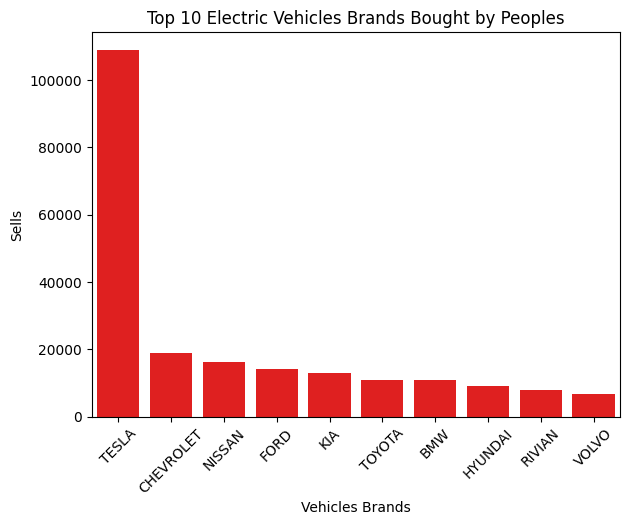


Electric vehicle model available:
+-------------+-----------------+---------+
|        Brand|    Vehicle_Model|Available|
+-------------+-----------------+---------+
|          KIA|         SPORTAGE|     1556|
|   LAND ROVER|      RANGE ROVER|       74|
|          BMW|               I4|     2069|
|MERCEDES-BENZ|        EQB-CLASS|      568|
|       RIVIAN|              R1T|     2561|
|          KIA|             SOUL|      575|
|     POLESTAR|              PS2|     1292|
|       SUBARU|         SOLTERRA|     2448|
|        LUCID|              AIR|      494|
|      HYUNDAI|           TUCSON|      680|
|          BMW|               I8|       97|
|         AUDI|     RS E-TRON GT|       65|
|         MINI|       COUNTRYMAN|      397|
|          BMW|               I5|      278|
|       TOYOTA|             BZ4X|     1739|
|      PORSCHE|            MACAN|      269|
|        VOLVO|             XC60|     1847|
|       TOYOTA|RAV4 PRIME (PHEV)|     4323|
|MERCEDES-BENZ|          B-CLASS|       8

In [4]:
main.createOrReplaceTempView("vehicles") #creates temporary view of DataFrame to fire SQL queries

print(f"Electric vehicle bought by peoples:")
df1=spark.sql("Select Make as Brand , count(*) as Peoples from vehicles group by Make") #.sql() used to fire sql queries inside of the python code
df1.show()

df3=df1.toPandas().sort_values(by='Peoples',ascending=False)
plt.Figure(figsize=(10,6))
sns.barplot(x='Brand',y='Peoples',data=df3.head(10),color='red')
plt.title("Top 10 Electric Vehicles Brands Bought by Peoples")
plt.xlabel("Vehicles Brands")
plt.ylabel("Sells")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

print(f"\nElectric vehicle model available:")
df2=spark.sql("Select Make as Brand ,Model as Vehicle_Model , count(*) as Available from vehicles group by Make, Model")
df2.show()

#### ML Model To Predict Future Sales OF TESLA

- ##### Select Data

In [5]:
df_time = spark.sql("""
    SELECT Make AS Brand, `Model Year` AS Model_Year, COUNT(*) AS Count
    FROM vehicles
    WHERE Make = 'TESLA'
    GROUP BY Make, `Model Year`
    ORDER BY `Model Year`
""")

- ##### Convert to ML-Friendly Format

In [6]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Model_Year"], outputCol="features")
df_ml = assembler.transform(df_time)

- ##### Train a Regression Model

In [7]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="Count")
model = lr.fit(df_ml)

# Predict for future years
future_years = spark.createDataFrame([(2027,), (2028,), (2029,), (2030,)], ["Model_Year"])
future_data = assembler.transform(future_years)
predictions = model.transform(future_data)
predictions.select("Model_Year", "prediction").show()

+----------+------------------+
|Model_Year|        prediction|
+----------+------------------+
|      2027|15448.064794052392|
|      2028|16432.298319011228|
|      2029|17416.531843970297|
|      2030|18400.765368929133|
+----------+------------------+



- ##### Convert to Pandas DataFrame

In [8]:
predictions_pd = predictions.select("Model_Year", "prediction").toPandas()
print(f"Future Sales of TESLA in Specific years:\n{predictions_pd}")

Future Sales of TESLA in Specific years:
   Model_Year    prediction
0        2027  15448.064794
1        2028  16432.298319
2        2029  17416.531844
3        2030  18400.765369


#### Converting Spark DataFrame into Pandas DataFrame

In [9]:
vehiclesdf=main.toPandas()
if vehiclesdf.empty == False: #check whether DataFrame is empty or not
    print("Converted Successfully")

Converted Successfully


#### Inspect DataFrame

In [10]:
print("Information of DataFrame:")
vehiclesdf.info() #provides info about DataFrame like number of non-null entries, data types of columns, memory usage etc.

print("\nDescription of DataFrame:")
vehiclesdf.describe() #provides statistical summary about dataframe.

Information of DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261698 entries, 0 to 261697
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Id                                                 261698 non-null  object 
 1   Country                                            261688 non-null  object 
 2   City                                               261688 non-null  object 
 3   State                                              261698 non-null  object 
 4   Postal Code                                        261688 non-null  float64
 5   Model Year                                         261698 non-null  int32  
 6   Make                                               261698 non-null  object 
 7   Model                                              261698 non-null  object 
 8   Electric Vehicle Type                           

,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Trac
count,261688.000000,261698.000000,261695.000000,261695.000000,261070.000000,2.616980e+05,2.616880e+05
mean,98176.150699,2021.772493,42.615071,695.503563,28.881955,2.412577e+08,5.297261e+10
std,2555.753410,3.034041,81.226054,6943.019653,14.889697,6.574252e+07,1.628791e+09
min,1469.000000,2000.000000,0.000000,0.000000,1.000000,4.385000e+03,1.001020e+09
25%,98052.000000,2020.000000,0.000000,0.000000,17.000000,2.150419e+08,5.303301e+10
50%,98133.000000,2023.000000,0.000000,0.000000,32.000000,2.594588e+08,5.303303e+10
75%,98382.000000,2024.000000,35.000000,0.000000,42.000000,2.746481e+08,5.305307e+10
max,99577.000000,2026.000000,337.000000,845000.000000,49.000000,4.791150e+08,6.601095e+10


##### Removing Null values

In [11]:
vehiclesdf=vehiclesdf.dropna()
print("\nAfter removing null values the shape of DataFrame is:",vehiclesdf.shape)
vehiclesdf.info()


After removing null values the shape of DataFrame is: (261059, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 261059 entries, 0 to 261697
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Id                                                 261059 non-null  object 
 1   Country                                            261059 non-null  object 
 2   City                                               261059 non-null  object 
 3   State                                              261059 non-null  object 
 4   Postal Code                                        261059 non-null  float64
 5   Model Year                                         261059 non-null  int32  
 6   Make                                               261059 non-null  object 
 7   Model                                              261059 non-null  object 
 8   Electric Ve

##### TESLA

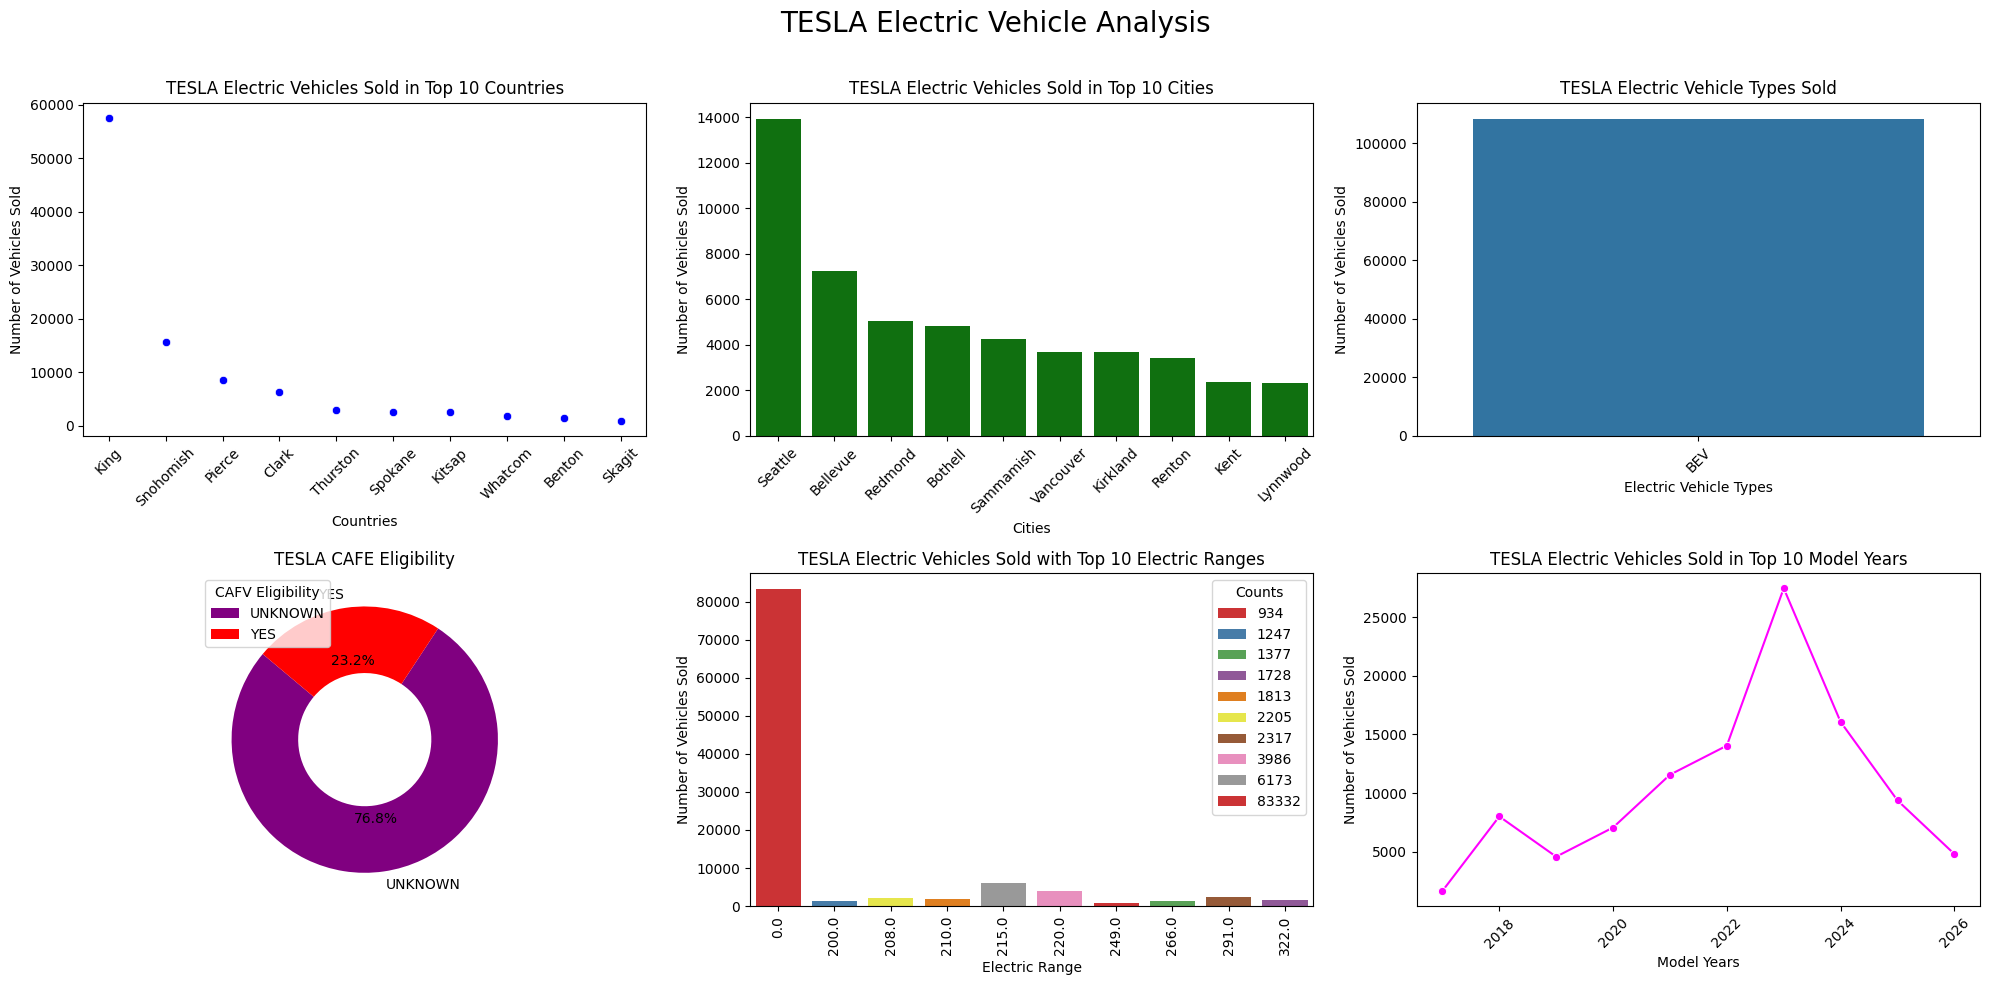

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='TESLA'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("TESLA Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='TESLA'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("TESLA Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='TESLA'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("TESLA Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='TESLA'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("TESLA CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='TESLA'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("TESLA Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='TESLA'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("TESLA Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("TESLA Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()

##### CHEVROLET

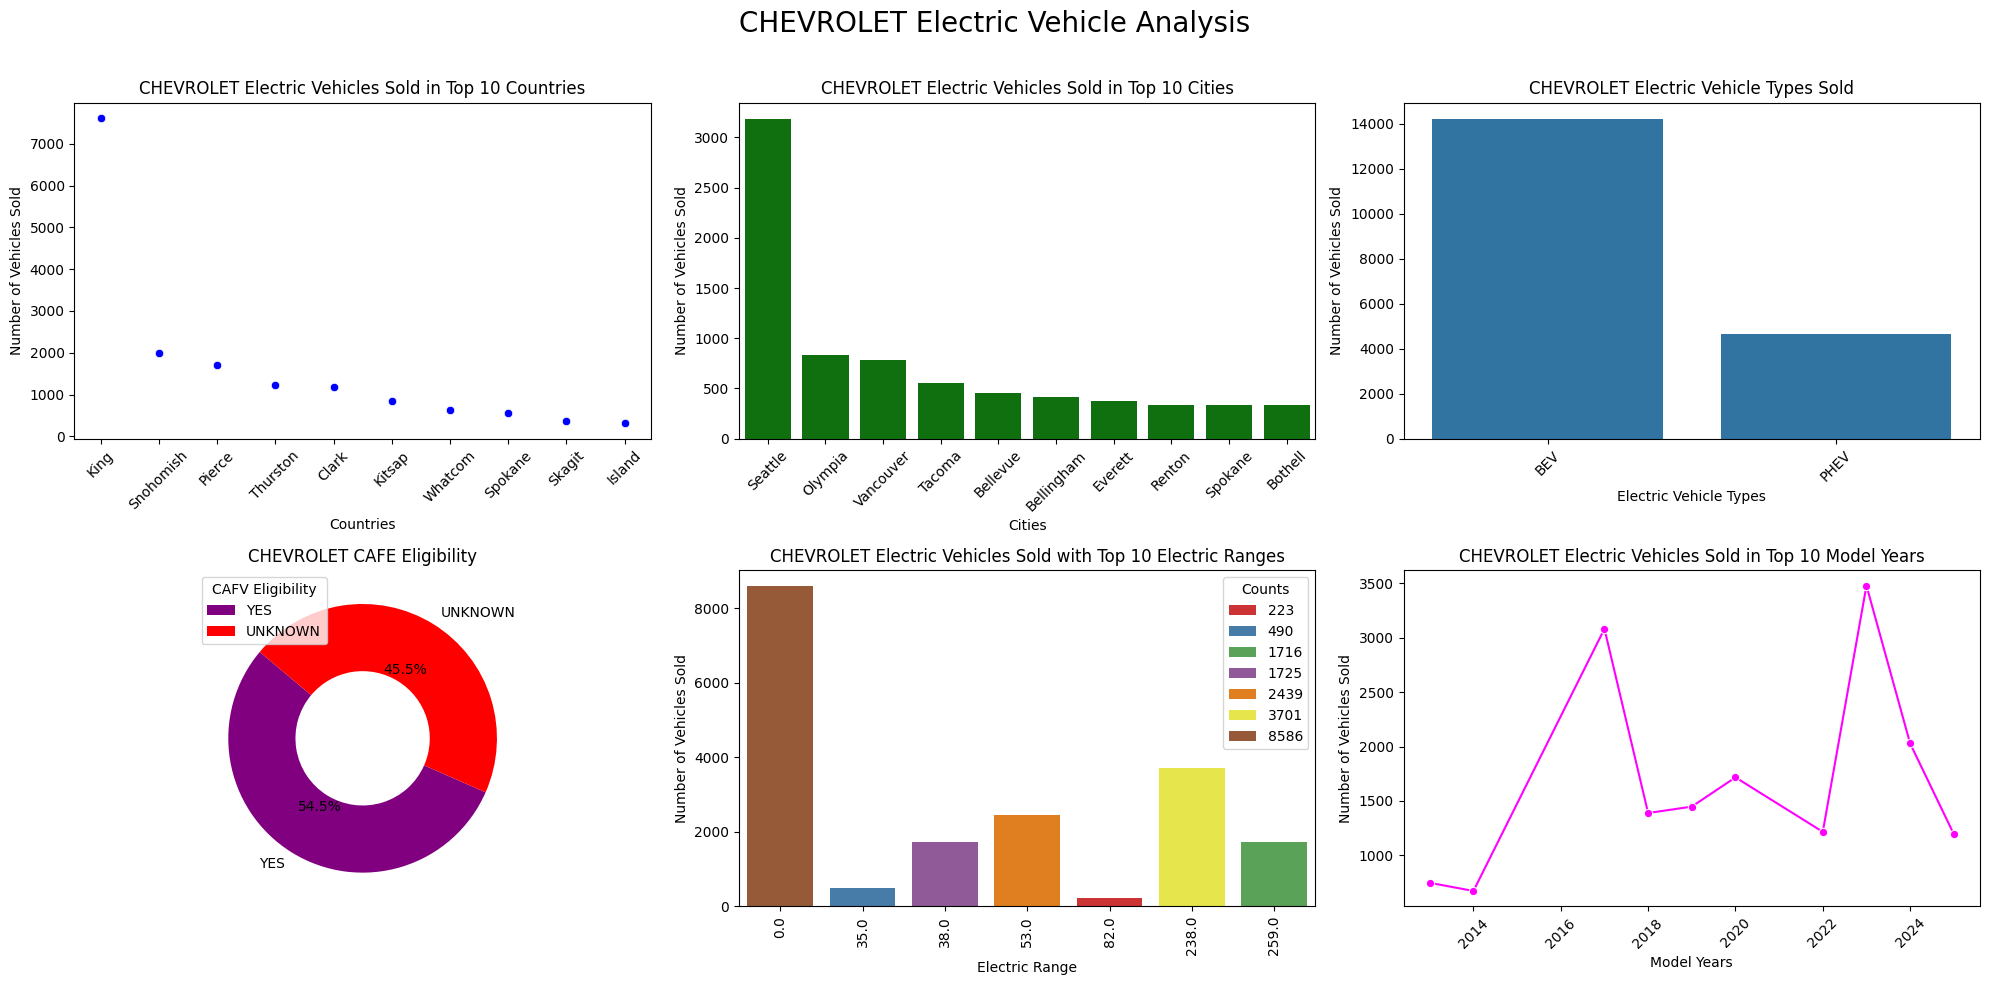

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='CHEVROLET'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("CHEVROLET Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='CHEVROLET'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("CHEVROLET Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='CHEVROLET'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("CHEVROLET Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='CHEVROLET'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("CHEVROLET CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='CHEVROLET'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("CHEVROLET Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='CHEVROLET'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("CHEVROLET Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("CHEVROLET Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()

##### NISSAN

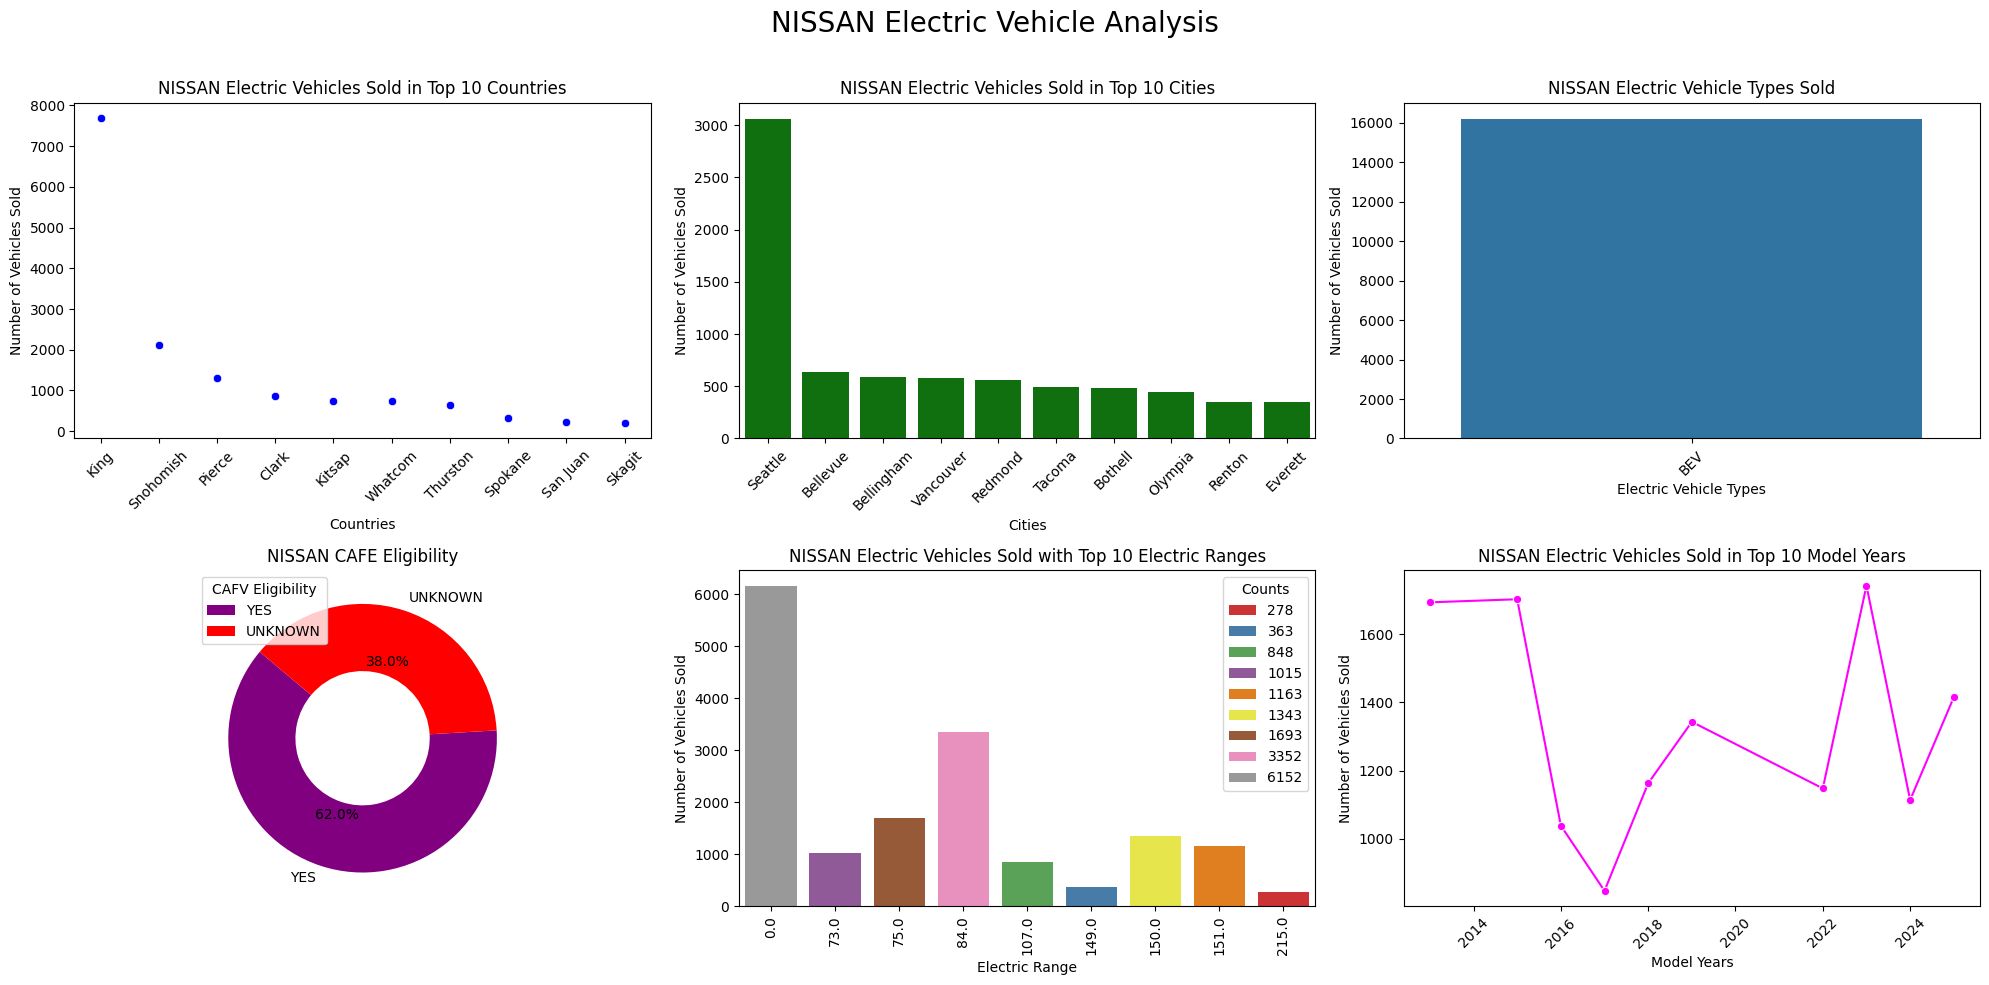

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='NISSAN'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("NISSAN Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='NISSAN'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("NISSAN Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='NISSAN'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("NISSAN Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='NISSAN'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("NISSAN CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='NISSAN'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("NISSAN Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='NISSAN'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("NISSAN Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("NISSAN Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()

##### FORD

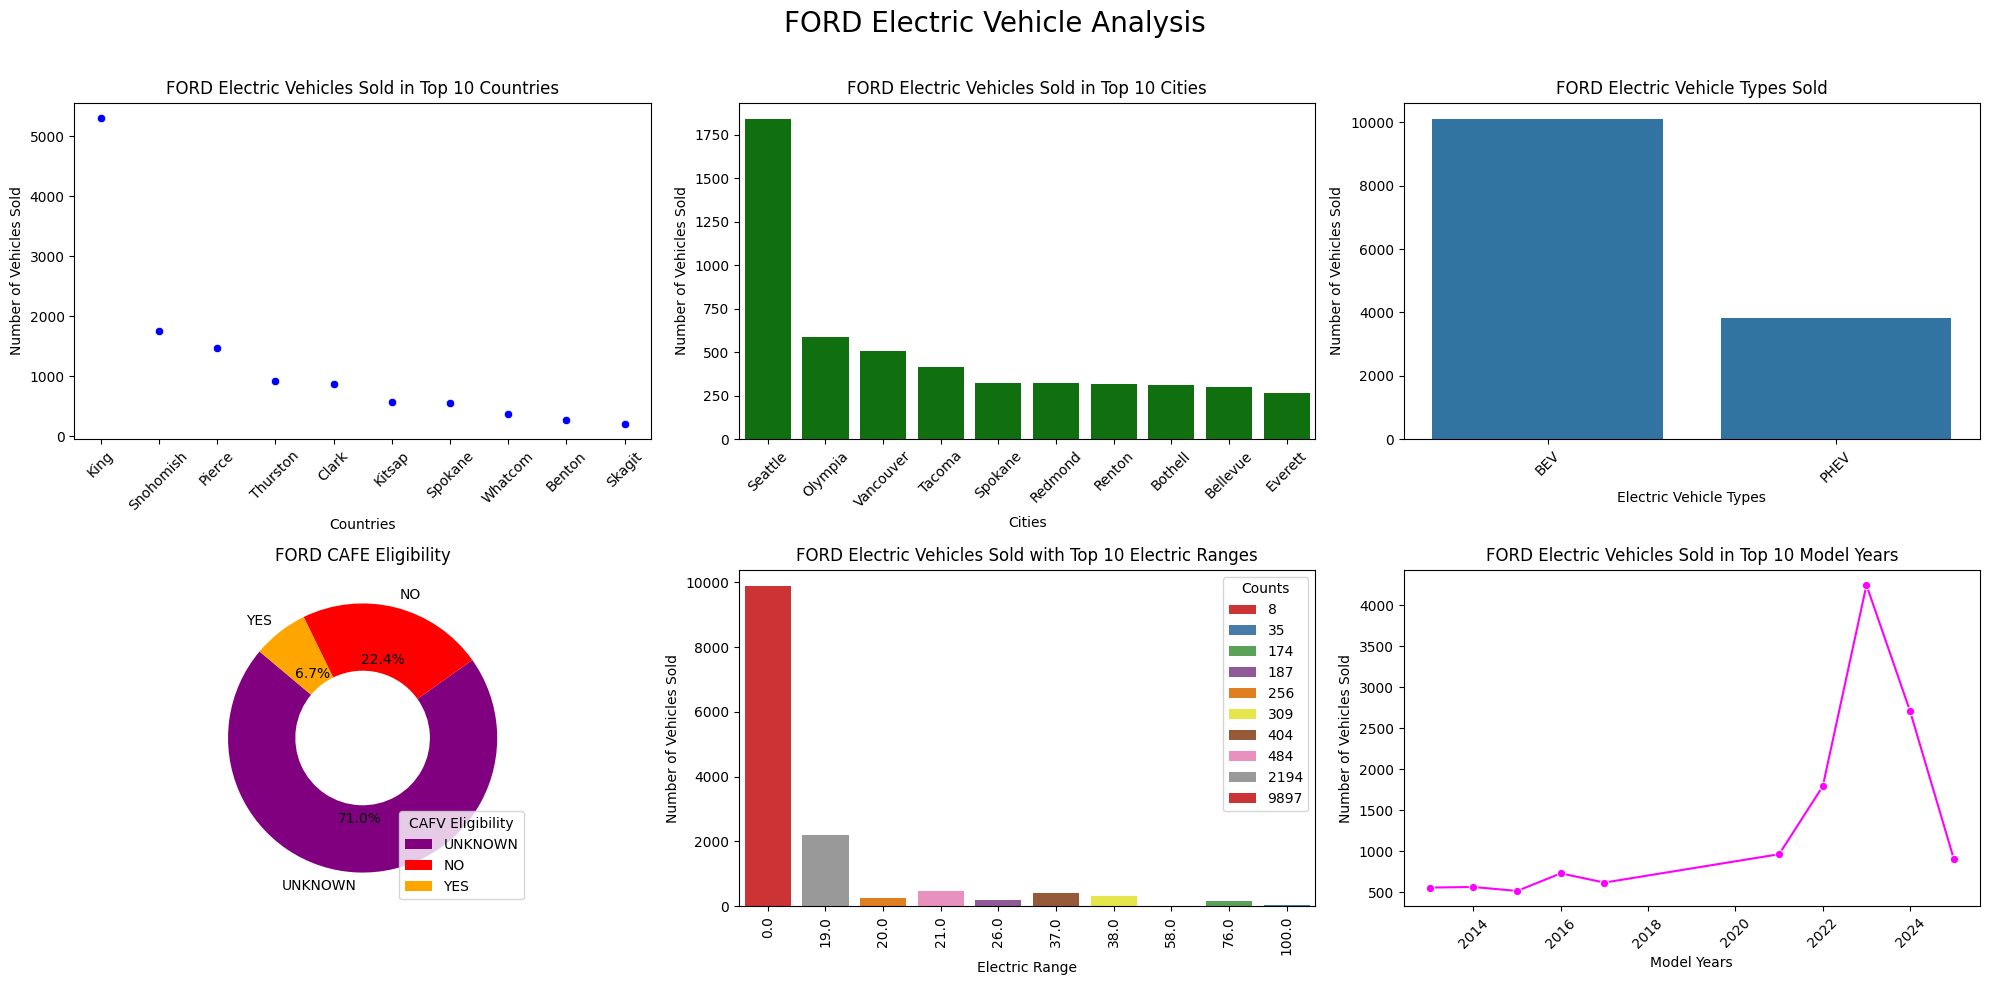

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='FORD'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("FORD Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='FORD'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("FORD Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='FORD'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("FORD Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='FORD'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red','orange'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("FORD CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='FORD'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("FORD Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='FORD'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("FORD Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("FORD Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()

##### KIA

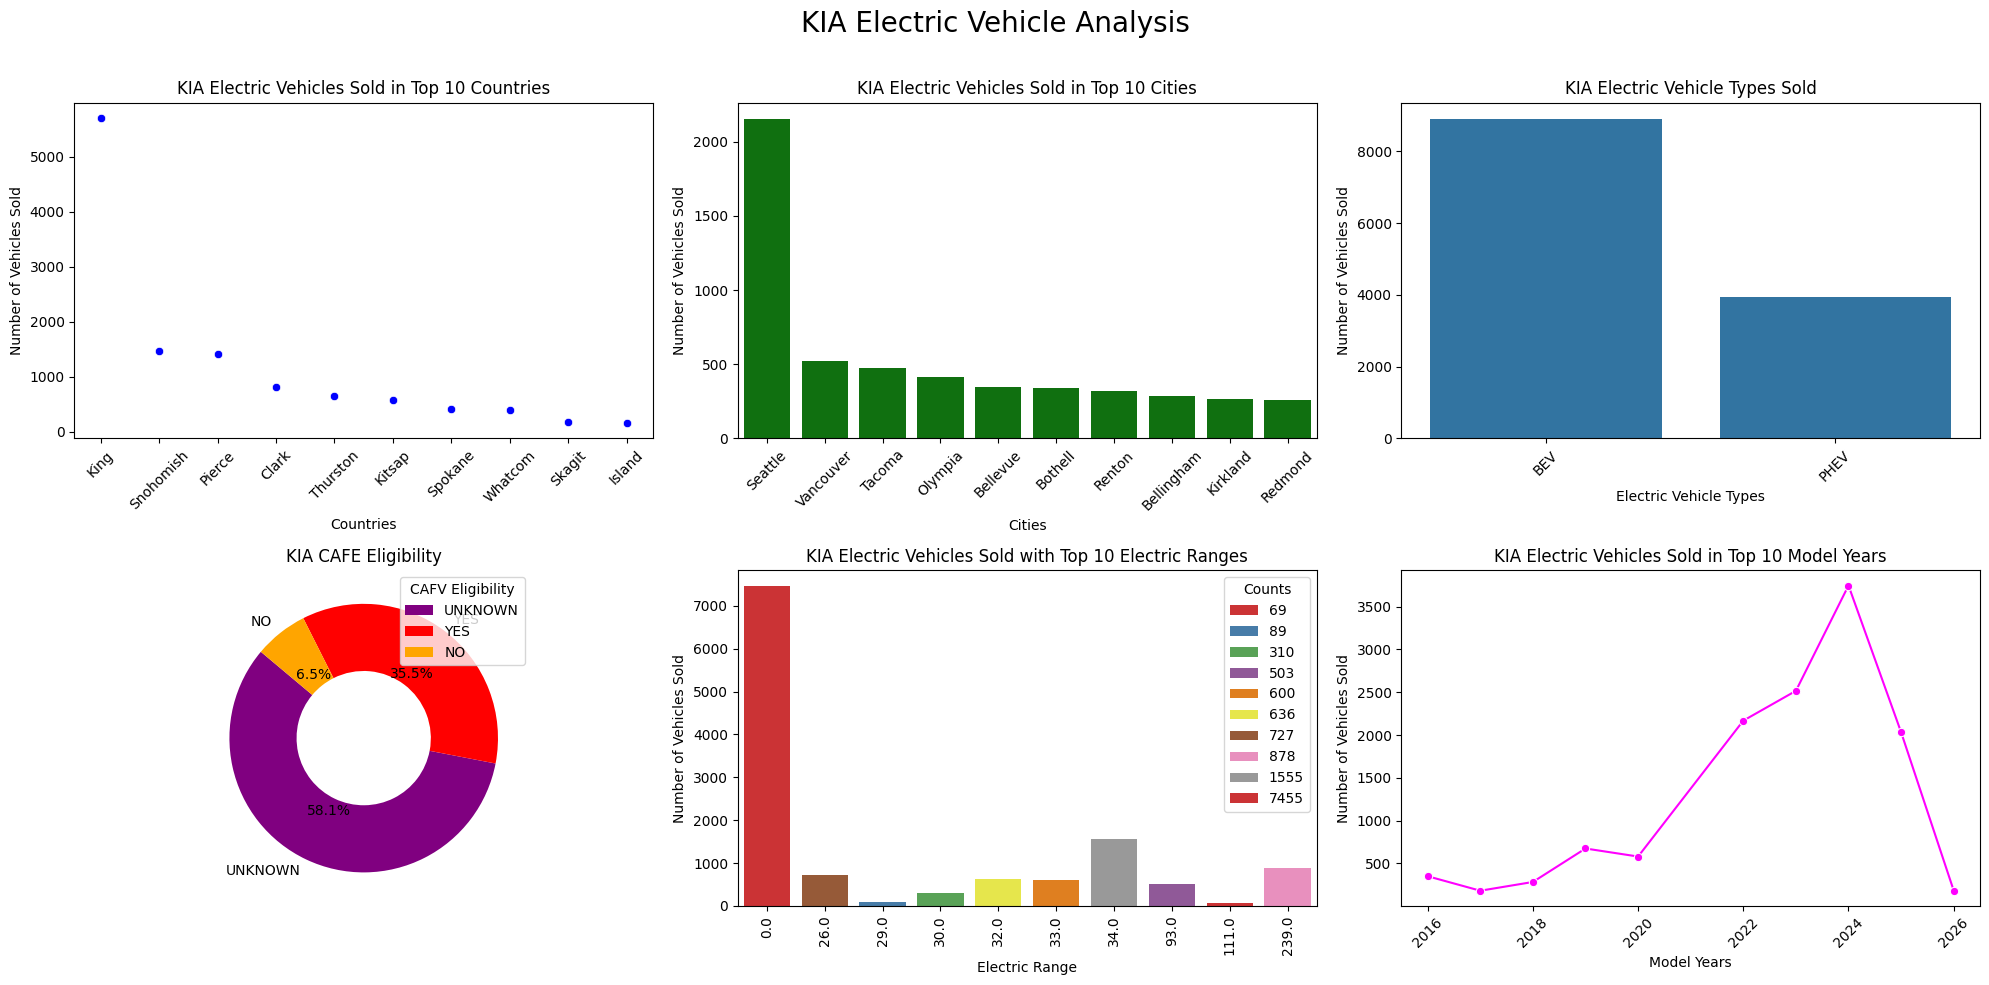

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='KIA'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("KIA Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='KIA'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("KIA Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='KIA'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("KIA Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='KIA'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red','orange'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("KIA CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='KIA'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("KIA Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='KIA'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("KIA Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("KIA Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()

##### TOYOTA

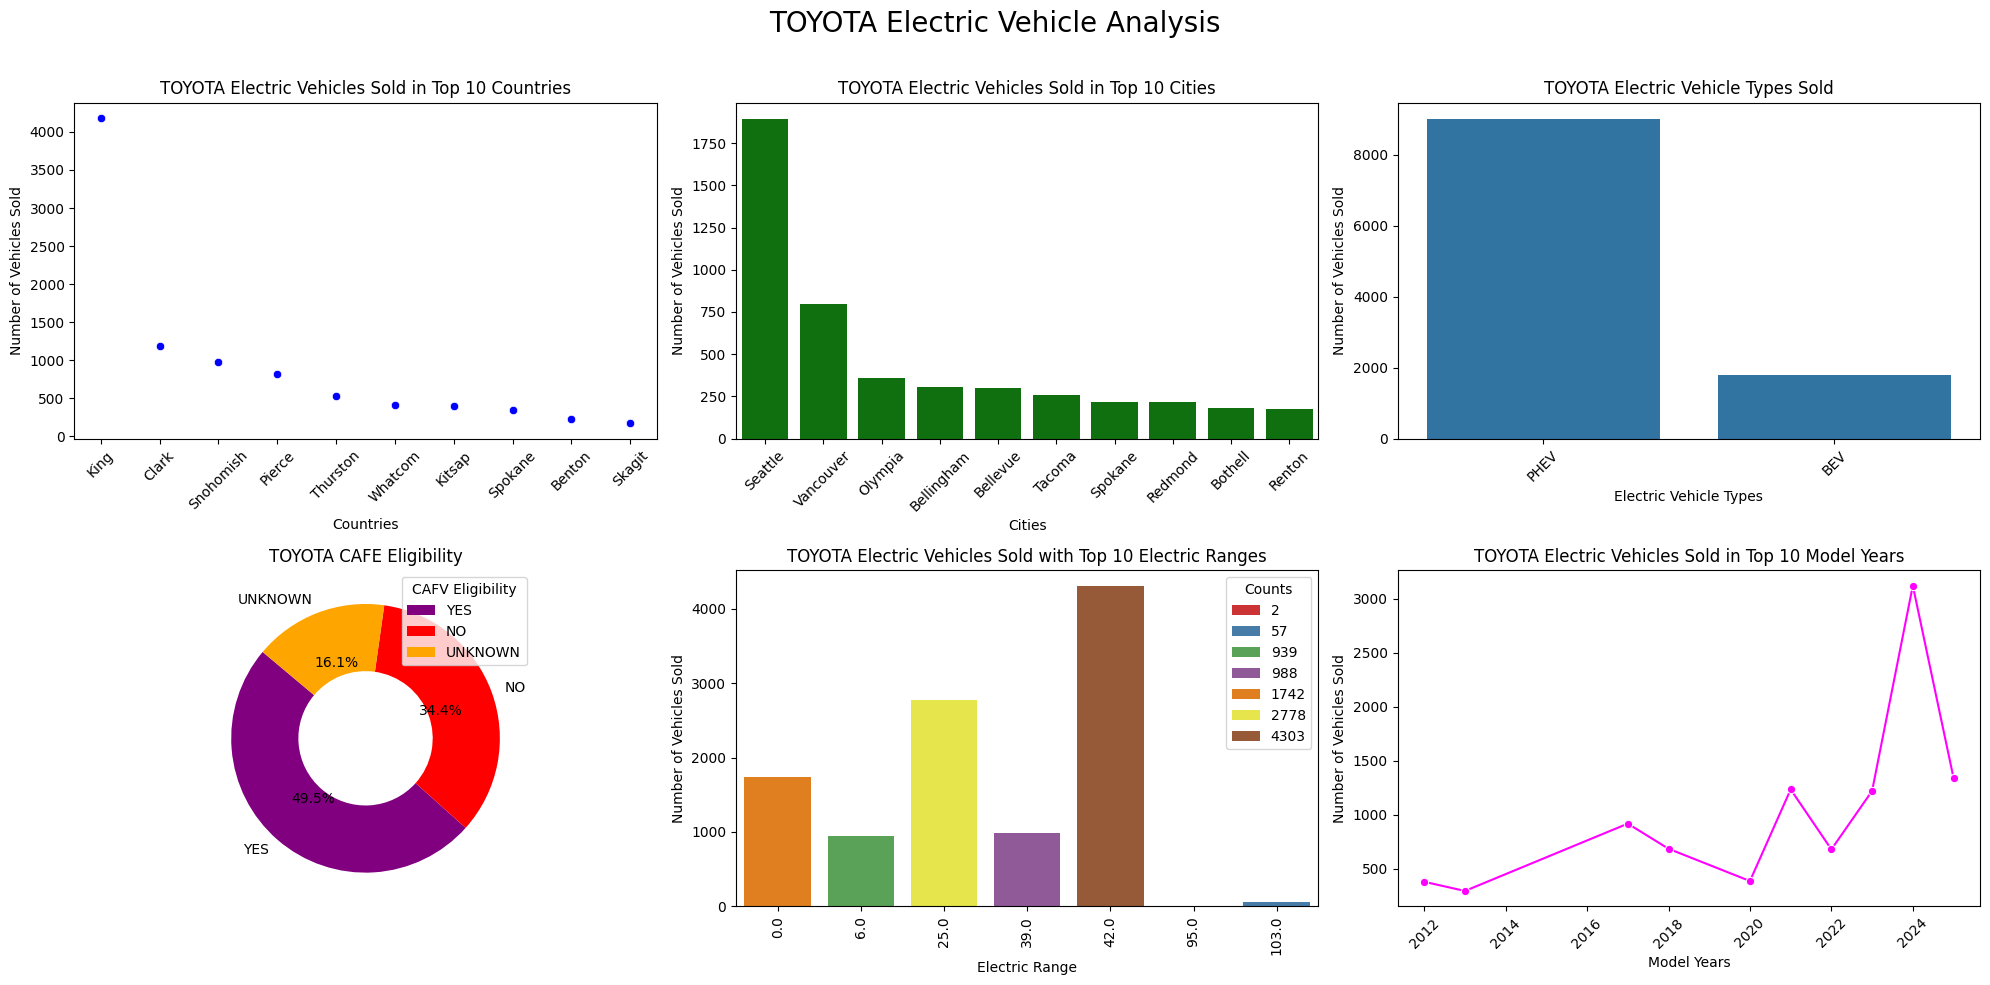

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='TOYOTA'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("TOYOTA Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='TOYOTA'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("TOYOTA Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='TOYOTA'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("TOYOTA Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='TOYOTA'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red','orange'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("TOYOTA CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='TOYOTA'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("TOYOTA Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='TOYOTA'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("TOYOTA Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("TOYOTA Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()

##### BMW

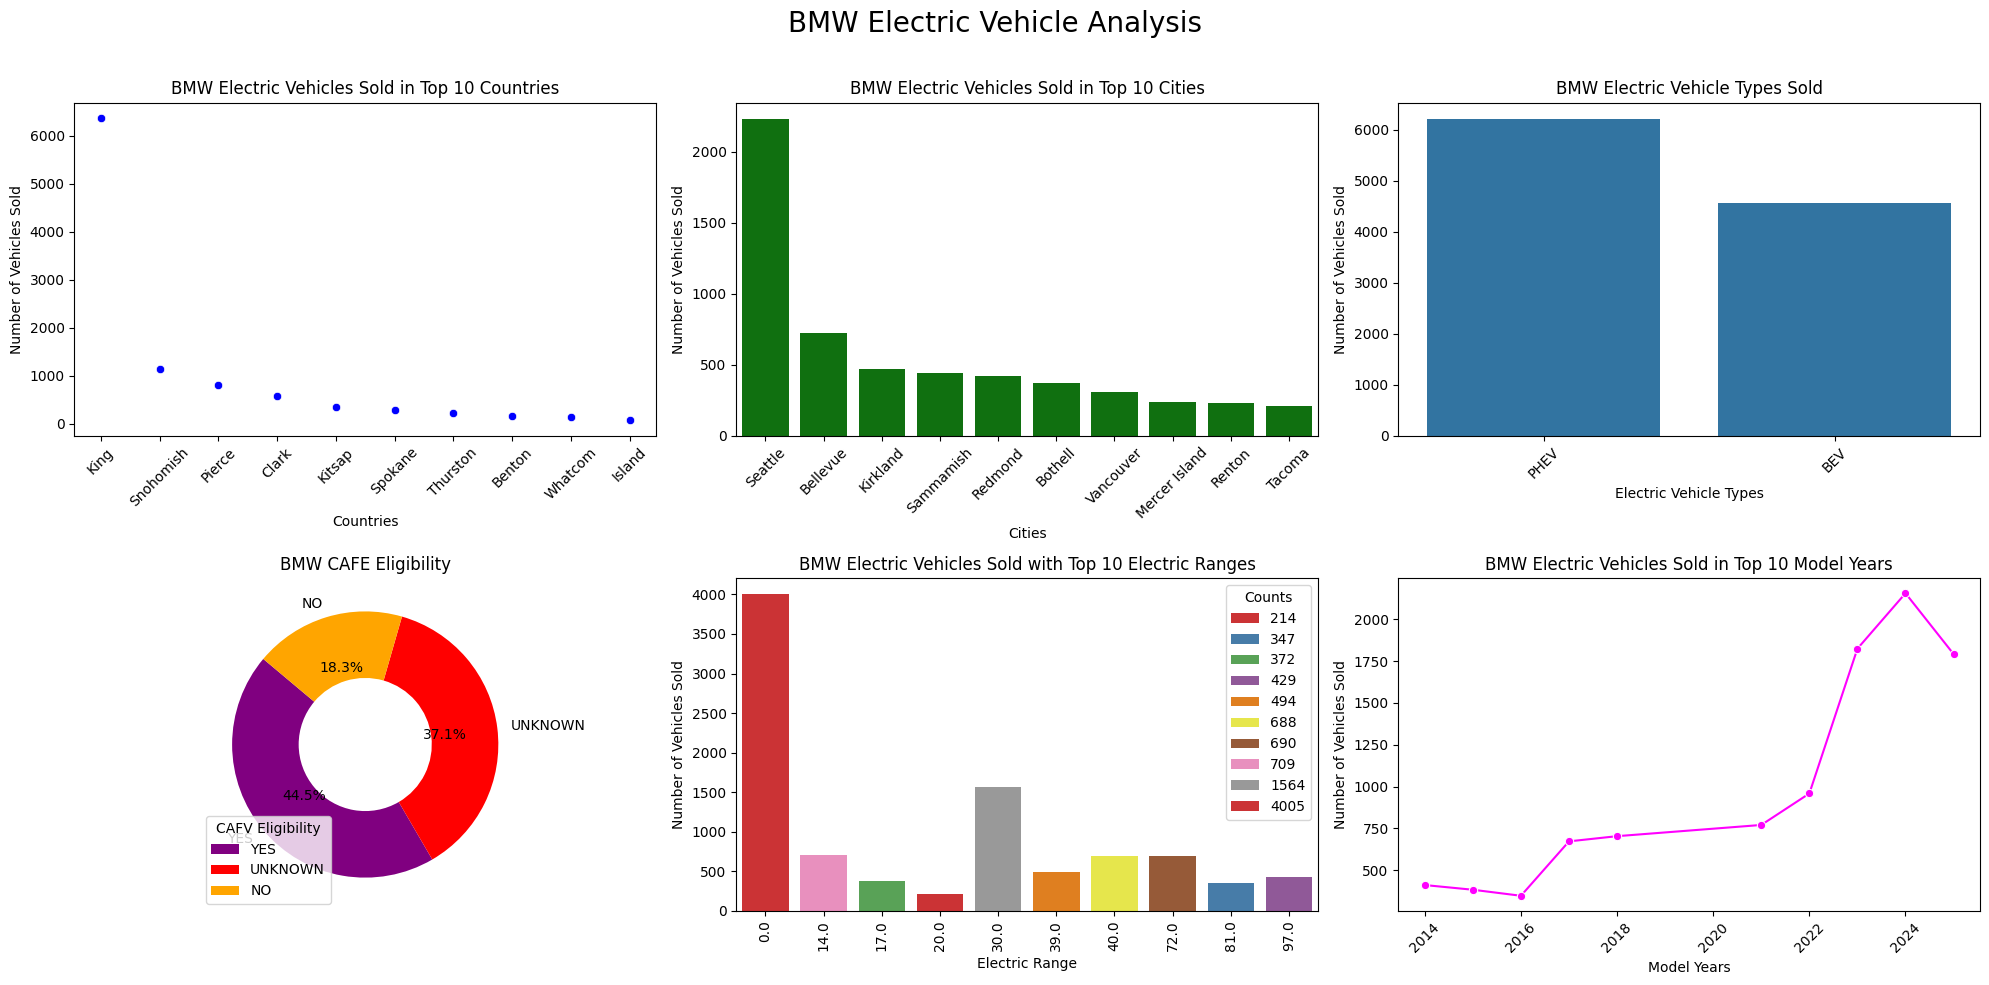

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='BMW'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("BMW Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='BMW'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("BMW Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='BMW'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("BMW Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='BMW'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red','orange'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("BMW CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='BMW'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("BMW Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='BMW'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("BMW Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("BMW Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()

##### HYUNDAI

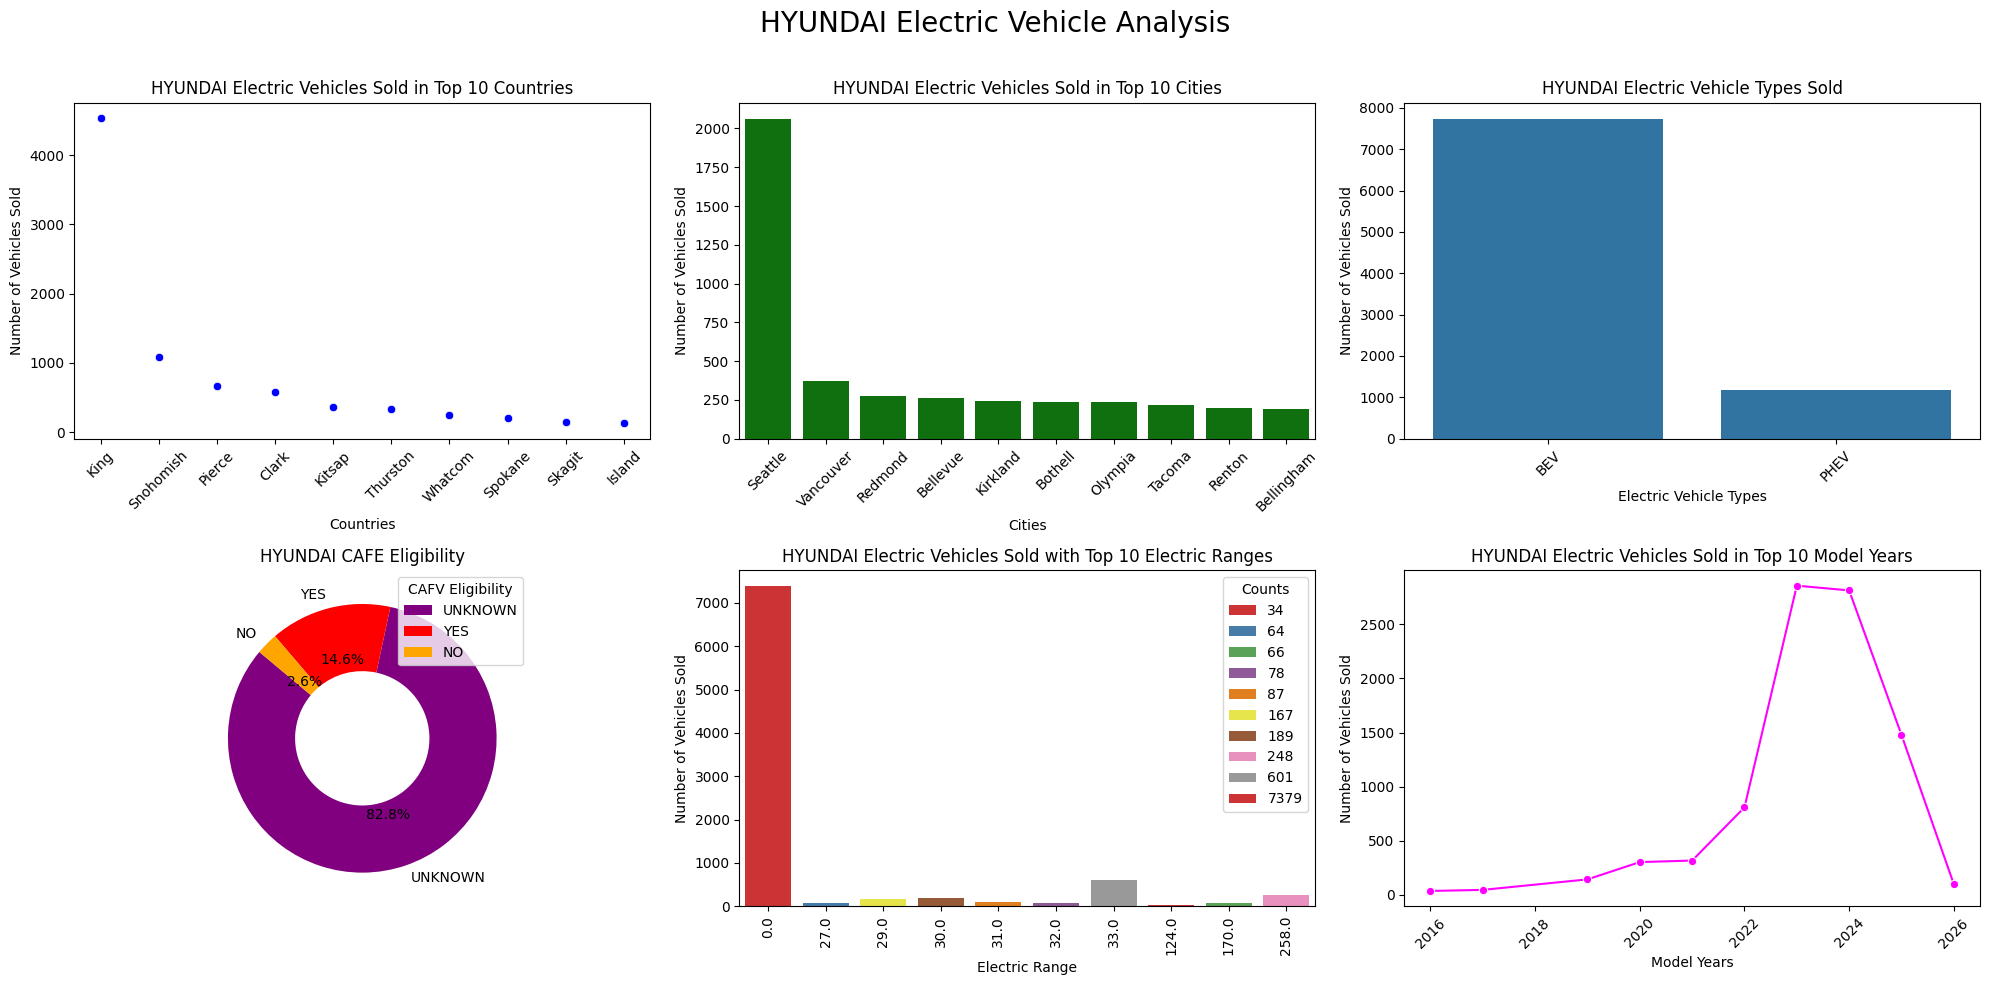

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='HYUNDAI'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("HYUNDAI Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='HYUNDAI'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("HYUNDAI Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='HYUNDAI'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("HYUNDAI Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='HYUNDAI'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red','orange'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("HYUNDAI CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='HYUNDAI'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("HYUNDAI Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='HYUNDAI'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("HYUNDAI Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("HYUNDAI Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()

##### RIVIAN

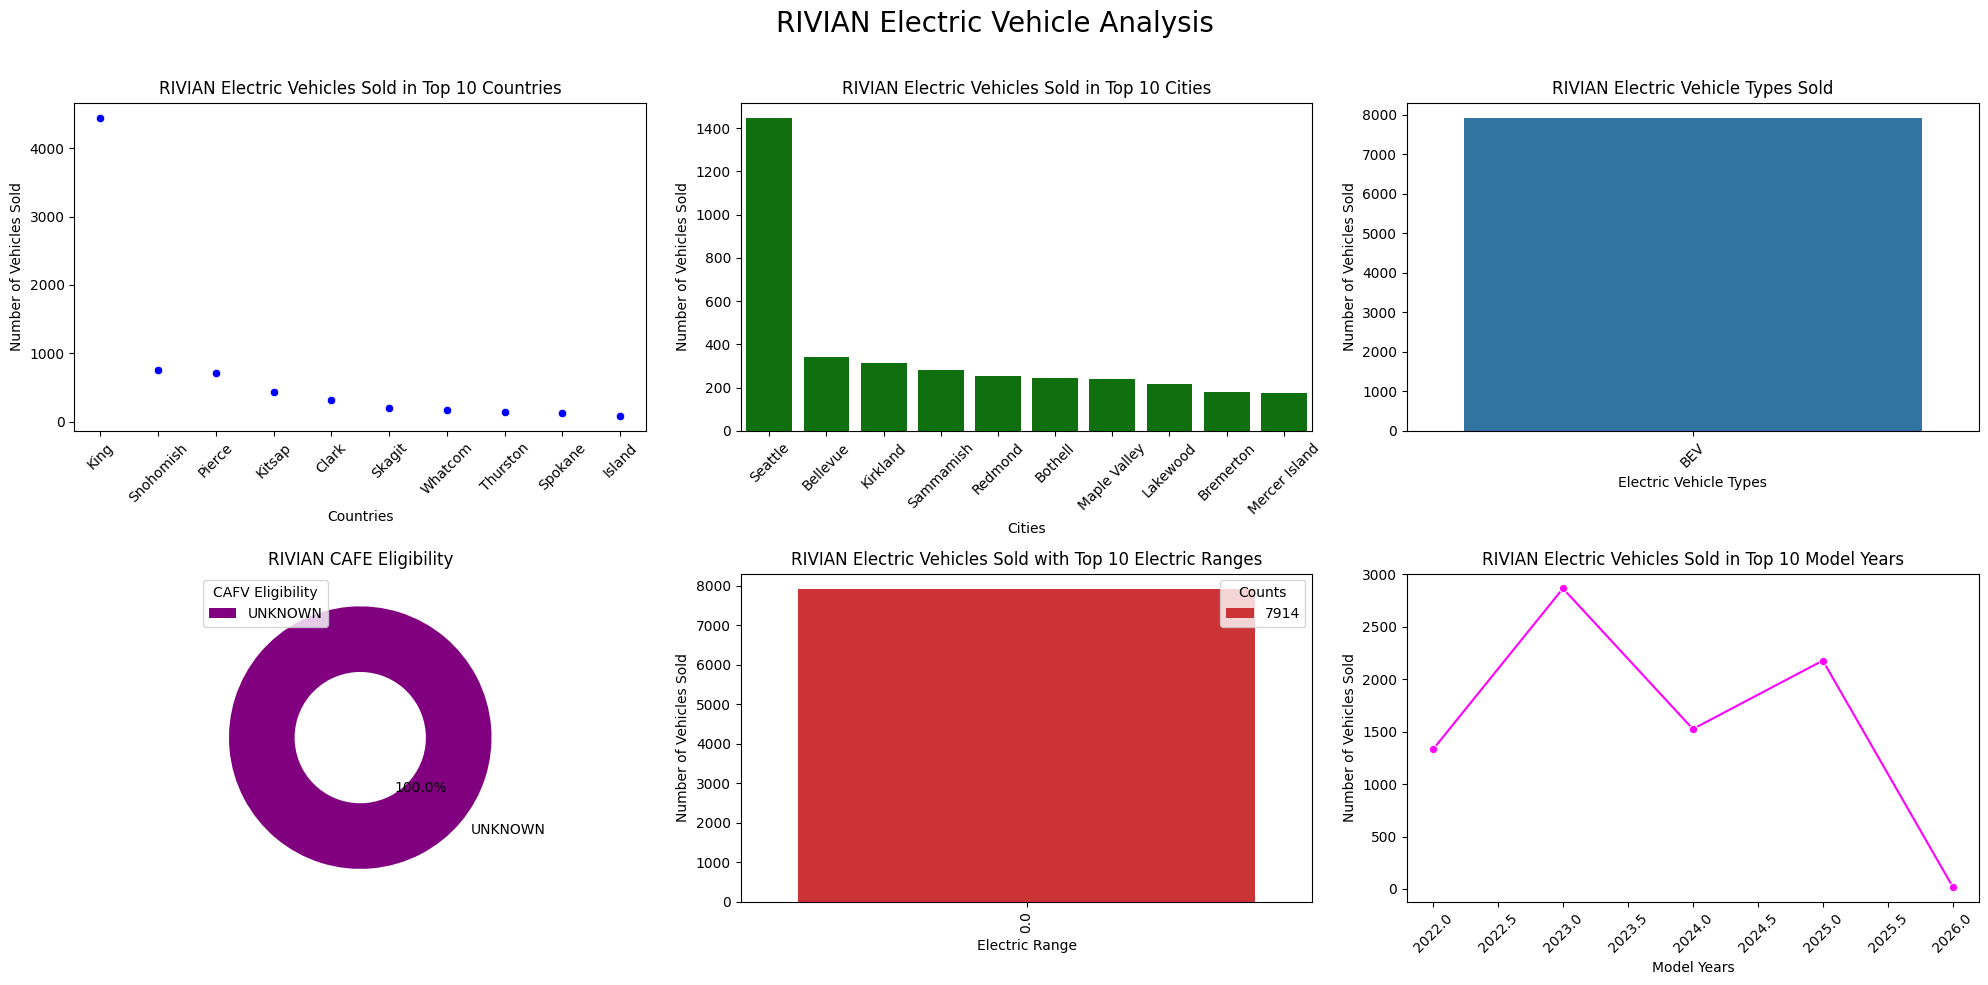

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='RIVIAN'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("RIVIAN Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='RIVIAN'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("RIVIAN Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='RIVIAN'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("RIVIAN Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='RIVIAN'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red','orange'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("RIVIAN CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='RIVIAN'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("RIVIAN Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='RIVIAN'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("RIVIAN Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("RIVIAN Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()

##### VOLVO

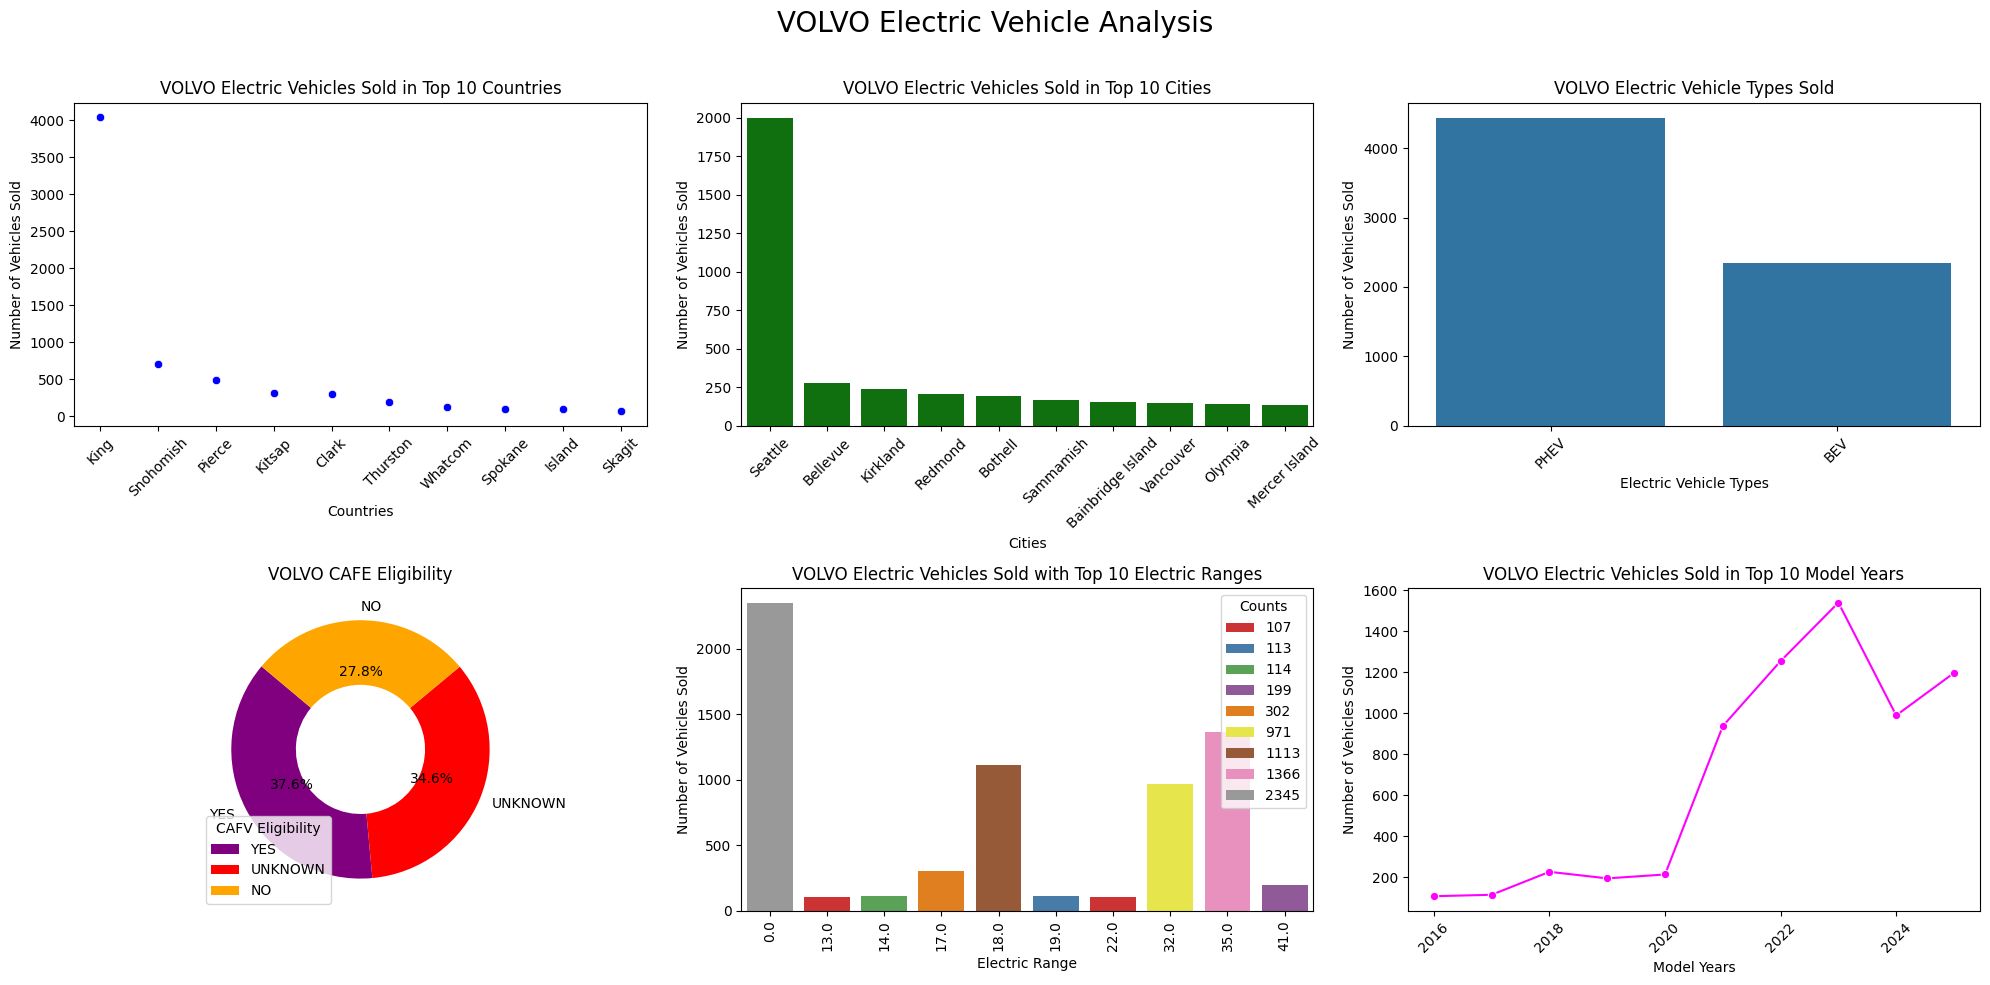

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()


countrydf=vehiclesdf[vehiclesdf['Make']=='VOLVO'].groupby('Country').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.scatterplot(x='Country',y='Counts',data=countrydf,color='blue',ax=ax1)
ax1.set_title("VOLVO Electric Vehicles Sold in Top 10 Countries")
ax1.set_xlabel("Countries")
ax1.set_ylabel("Number of Vehicles Sold")
ax1.tick_params(axis='x', rotation=45)

citydf=vehiclesdf[vehiclesdf['Make']=='VOLVO'].groupby('City').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='City',y='Counts',data=citydf,color='green',ax=ax2)
ax2.set_title("VOLVO Electric Vehicles Sold in Top 10 Cities")
ax2.set_xlabel("Cities")
ax2.set_ylabel("Number of Vehicles Sold")
ax2.tick_params(axis='x', rotation=45)

vehitypdf=vehiclesdf[vehiclesdf['Make']=='VOLVO'].groupby('Electric Vehicle Type').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Vehicle Type',y='Counts',data=vehitypdf,ax=ax3)
ax3.set_title("VOLVO Electric Vehicle Types Sold")
ax3.set_xlabel("Electric Vehicle Types")
ax3.set_ylabel("Number of Vehicles Sold")
ax3.tick_params(axis='x', rotation=45)

cafv_eligdf=vehiclesdf[vehiclesdf['Make']=='VOLVO'].groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
ax4.pie(cafv_eligdf['Counts'], labels=cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], colors=['purple','red','orange'] ,autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
ax4.set_title("VOLVO CAFE Eligibility")
ax4.legend(cafv_eligdf['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], title="CAFV Eligibility", loc="best")

statedf=vehiclesdf[vehiclesdf['Make']=='VOLVO'].groupby('Electric Range').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.barplot(x='Electric Range',y='Counts',data=statedf,color='cyan',ax=ax5,hue='Counts',palette='Set1', dodge=False)
ax5.set_title("VOLVO Electric Vehicles Sold with Top 10 Electric Ranges")
ax5.set_xlabel("Electric Range")
ax5.set_ylabel("Number of Vehicles Sold")
ax5.tick_params(axis='x', rotation=90)

yeardf=vehiclesdf[vehiclesdf['Make']=='VOLVO'].groupby('Model Year').size().reset_index(name='Counts').sort_values(by='Counts',ascending=False).head(10)
sns.lineplot(x='Model Year',y='Counts',data=yeardf,color='magenta',marker='o',ax=ax6)
ax6.set_title("VOLVO Electric Vehicles Sold in Top 10 Model Years")
ax6.set_xlabel("Model Years")
ax6.set_ylabel("Number of Vehicles Sold")
ax6.tick_params(axis='x', rotation=45)
plt.suptitle("VOLVO Electric Vehicle Analysis\n", fontsize=20)
plt.tight_layout()
plt.show()